# Inference Notebook

Run single-molecule inference with a trained checkpoint and visualize prediction quality (IoU/Dice).


In [13]:
from pathlib import Path
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

def find_repo_root(start: Path) -> Path:
    current = start.resolve()
    for parent in [current, *current.parents]:
        if (parent / 'src').exists() and (parent / 'README.md').exists():
            return parent
    raise RuntimeError('Could not find repo root containing src/ and README.md')

repo_root = find_repo_root(Path.cwd())
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

print('Repo root:', repo_root)
print('CUDA available:', torch.cuda.is_available())


Repo root: ../
CUDA available: True


## Config

Edit these paths before running inference.


In [18]:
from src.datasets import Ters_dataset_filtered_skip
from src.transforms import NormalizeVectorized, MinimumToZeroVectorized
from notebooks.utils.read_files import read_npz

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Pick one checkpoint and one NPZ to inspect
checkpoint_candidates = [
    repo_root / 'model_checkpoints' / 'best_model_0.05.pt',
]
model_path = next((p for p in checkpoint_candidates if p.exists()), checkpoint_candidates[0])
molecule_file = Path('/scratch/phys/sin/sethih1/Extended_TERS_data/planar_oct_2025/planar_again/planar_npz_0.05/test/101481.npz')

# Dataset options (should match training/eval settings)
num_channels = 100
frequency_range = [0, 4000]
circle_radius = 5

assert model_path.exists(), f'Model not found. Checked: {checkpoint_candidates}'
assert molecule_file.exists(), f'NPZ not found: {molecule_file}'
print('Using model:', model_path)
print('Using molecule:', molecule_file)
print('Device:', device)


Using model: ../model_checkpoints/best_model_0.05.pt
Using molecule: /scratch/phys/sin/sethih1/Extended_TERS_data/planar_oct_2025/planar_again/planar_npz_0.05/test/101481.npz
Device: cuda


In [15]:
def load_model(model_path: Path, device: torch.device):
    model_obj = torch.load(str(model_path), map_location=device)
    # Current training code saves the full model object.
    if hasattr(model_obj, 'eval'):
        model = model_obj
    else:
        raise TypeError('Unsupported checkpoint format. Expected a serialized nn.Module.')
    model.to(device)
    model.eval()
    return model

def compute_iou_dice(pred: torch.Tensor, mask: torch.Tensor):
    pred_flat = pred.view(-1).bool()
    mask_flat = mask.view(-1).bool()
    inter = torch.logical_and(pred_flat, mask_flat).sum().float()
    union = torch.logical_or(pred_flat, mask_flat).sum().float()
    iou = (inter / (union + 1e-6)).item()
    dice = (2 * inter / (pred_flat.sum().float() + mask_flat.sum().float() + 1e-6)).item()
    return iou, dice

def element_color(z: int) -> str:
    return {1: 'lightgray', 6: 'black', 7: '#1f77b4', 8: '#d62728', 9: '#2ca02c'}.get(int(z), 'gray')

def element_symbol(z: int) -> str:
    return {1:'H',2:'He',3:'Li',4:'Be',5:'B',6:'C',7:'N',8:'O',9:'F',10:'Ne'}.get(int(z), 'X')

def get_single_sample(dataset, npz_path: Path):
    stem = npz_path.stem
    idx = None
    for i, p in enumerate(dataset.names):
        if Path(p).stem == stem:
            idx = i
            break
    if idx is None:
        raise ValueError(f'{npz_path.name} not found in dataset folder {npz_path.parent}')

    filename, atom_count, _, images, _, mask = dataset[idx]
    return {
        'filename': filename,
        'atom_count': int(atom_count.item()) if torch.is_tensor(atom_count) else int(atom_count),
        'images': images,
        'mask': mask,
    }


In [16]:
data_transform = transforms.Compose([NormalizeVectorized(), MinimumToZeroVectorized()])

dataset = Ters_dataset_filtered_skip(
    filename=str(molecule_file.parent),
    frequency_range=frequency_range,
    num_channels=num_channels,
    std_deviation_multiplier=2,
    sg_ch=True,
    circle_radius=circle_radius,
    t_image=data_transform,
    t_freq=None,
    flag=True,
)

model = load_model(model_path, device)
sample = get_single_sample(dataset, molecule_file)

images = sample['images'].unsqueeze(0).to(device)
mask = sample['mask'].cpu()

with torch.no_grad():
    logits = model(images)
    probs = torch.sigmoid(logits)
    pred = (probs > 0.5).long().squeeze().cpu()

iou, dice = compute_iou_dice(pred, mask.squeeze())

atom_pos, atomic_numbers = read_npz(str(molecule_file))
avg_ters = sample['images'].mean(dim=0).cpu().numpy()

metrics_df = pd.DataFrame([{
    'filename': sample['filename'],
    'num_atoms': sample['atom_count'],
    'iou': iou,
    'dice': dice,
}])
metrics_df


/tmp/ipykernel_687153/587336348.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_obj = torch.load(str(model_path), map_location=device)


,filename,num_atoms,iou,dice
0,101481,20,0.72713,0.84201


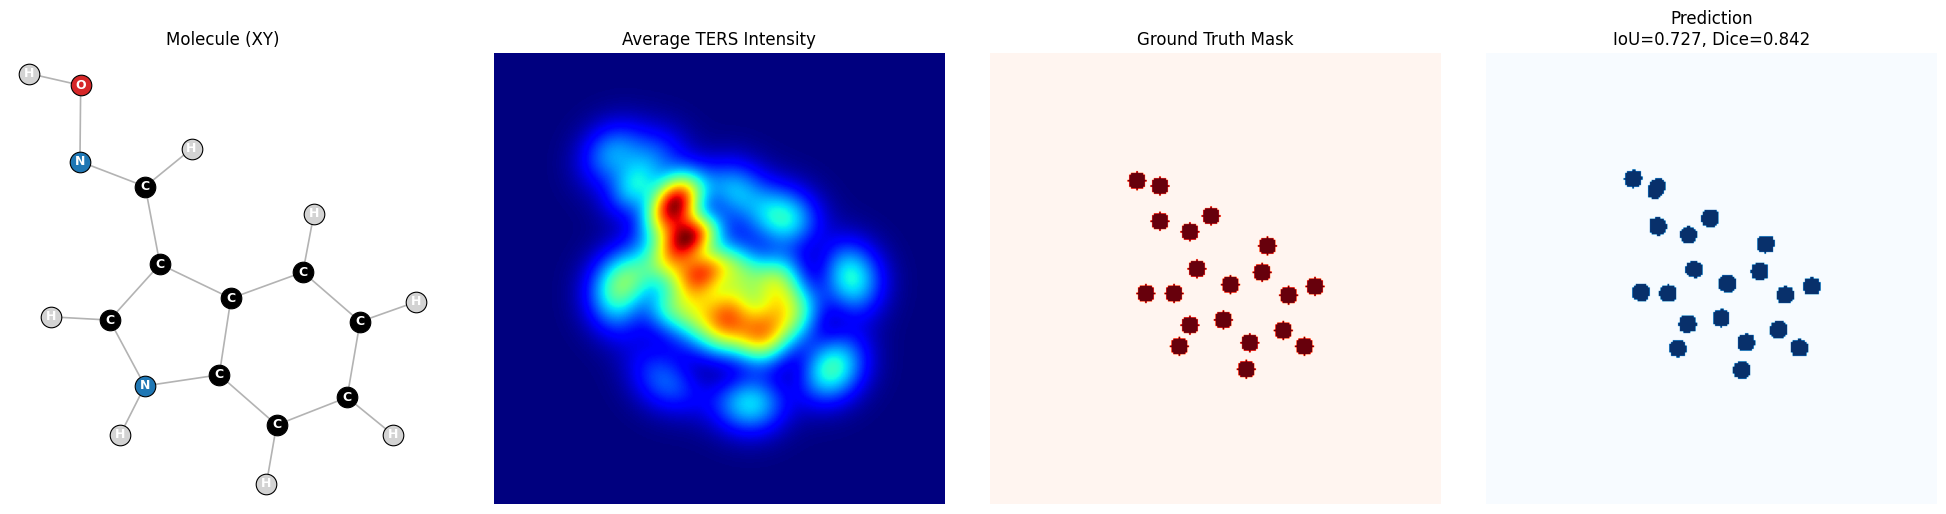

In [17]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# 1) Molecule structure (XY projection with simple bond threshold)
num_atoms = min(sample['atom_count'], len(atom_pos))
for i in range(num_atoms):
    for j in range(i + 1, num_atoms):
        if np.linalg.norm(atom_pos[i] - atom_pos[j]) < 1.6:
            axes[0].plot([atom_pos[i, 0], atom_pos[j, 0]], [atom_pos[i, 1], atom_pos[j, 1]], color='0.7', lw=1.2, zorder=1)
for i in range(num_atoms):
    x, y, _ = atom_pos[i]
    z = int(atomic_numbers[i])
    axes[0].scatter(x, y, s=220, c=element_color(z), edgecolors='black', linewidths=0.8, zorder=2)
    axes[0].text(x, y, element_symbol(z), ha='center', va='center', color='white', fontsize=9, fontweight='bold', zorder=3)
axes[0].set_aspect('equal')
axes[0].set_title('Molecule (XY)')
axes[0].axis('off')

# 2) Average TERS intensity
axes[1].imshow(avg_ters, cmap='jet', origin='lower')
axes[1].set_title('Average TERS Intensity')
axes[1].axis('off')

# 3) Ground-truth mask
axes[2].imshow(mask.squeeze().numpy(), cmap='Reds', origin='lower')
axes[2].set_title('Ground Truth Mask')
axes[2].axis('off')

# 4) Prediction
axes[3].imshow(pred.numpy(), cmap='Blues', origin='lower')
axes[3].set_title(f'Prediction\nIoU={iou:.3f}, Dice={dice:.3f}')
axes[3].axis('off')

plt.tight_layout()
plt.show()
